In [1]:
# Install pre-requisites

%pip install transformers timm datasets huggingface_hub

# Image classification

Conceptually, we will take as input an image and get back a _label_.

An image is represented in memory as a color map. Each pixel contains three values, representing the saturation of red, green and blue. These are also known as _channels_.

For our purposes, each image is represented as a three-dimensional tensor, where there is a 2-d "slice" per channel, representing the pixel value.

The output is simply a categorical value, with a label associated.

In [2]:
# Import the dependendies
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch # Will use torch directyly for certain manipulations
from datasets import load_dataset

# Load a processor and the classification model
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-50")

# Load a dataset
dataset = load_dataset("zh-plus/tiny-imagenet")
image = dataset["valid"]["image"][100]



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# Pre-process the image
inputs = processor(image, return_tensors="pt")
print(inputs['pixel_values'].shape)

torch.Size([1, 3, 224, 224])


isopod


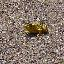

In [4]:
# Use this to avoid keeping track of gradients
with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()

# Use the model's config to get the label of the predicted class
print(model.config.id2label[predicted_label])
image

# Object detection

Similar to image classification, object detection finds several objects in an image and assigns labels to each one.

Every detection comes with a bounding box. This is a rectangle within the image that encloses an object.

In [5]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests



# We will use the DETR architecture. Similarly, we will use an image processor tagged with the model
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")




Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Detecting objects is a little bit involved, so wi will create a helper function
def detect_objects(image:Image):
  # Process the inputs to make them in the format we need or the model
  inputs = processor(images=image, return_tensors="pt")
  # Run the model and compute the output. This output contains bounding boxes and logits
  outputs = model(**inputs)

  # convert outputs (bounding boxes and class logits) to COCO API
  # let's only keep detections with score > 0.9, the onses with high conficende
  target_sizes = torch.tensor([image.size[::-1]])
  results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

  return results

# Write anothe helper function to display the predictions
def display_results(results):
  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

In [7]:
# Fetch an image from the internet and predict objects
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

predictions = detect_objects(image)
display_results(predictions)

Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]


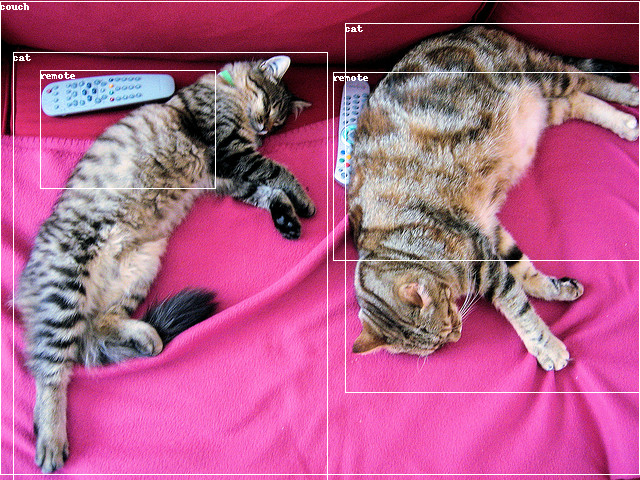

In [8]:
# We can also display the original image with the bounding boxes overlayed
from PIL import ImageDraw
config = model.config

# Again, let's code a helper function
def draw_objects(image, results, config, color="white"):
  # Using PIL, we can draw on top of a bitmap
  draw = ImageDraw.Draw(image)
  # For each prediction, we will draw the bounding box
  for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    x, y, w, h = tuple(box)
    x1, y1 = int(x), int(y)
    x2, y2 = int(x + w), int(y + h)

    draw.rectangle((x, y, x + w, y + h), outline=color, width=1)
    draw.text((x, y), config.id2label[label.item()], fill=color)

draw_objects(image, predictions, config)
image

Detected person with confidence 0.985 at location [1.69, 4.97, 1007.97, 1266.61]
Detected dog with confidence 0.998 at location [692.7, 6.08, 1277.84, 1264.94]


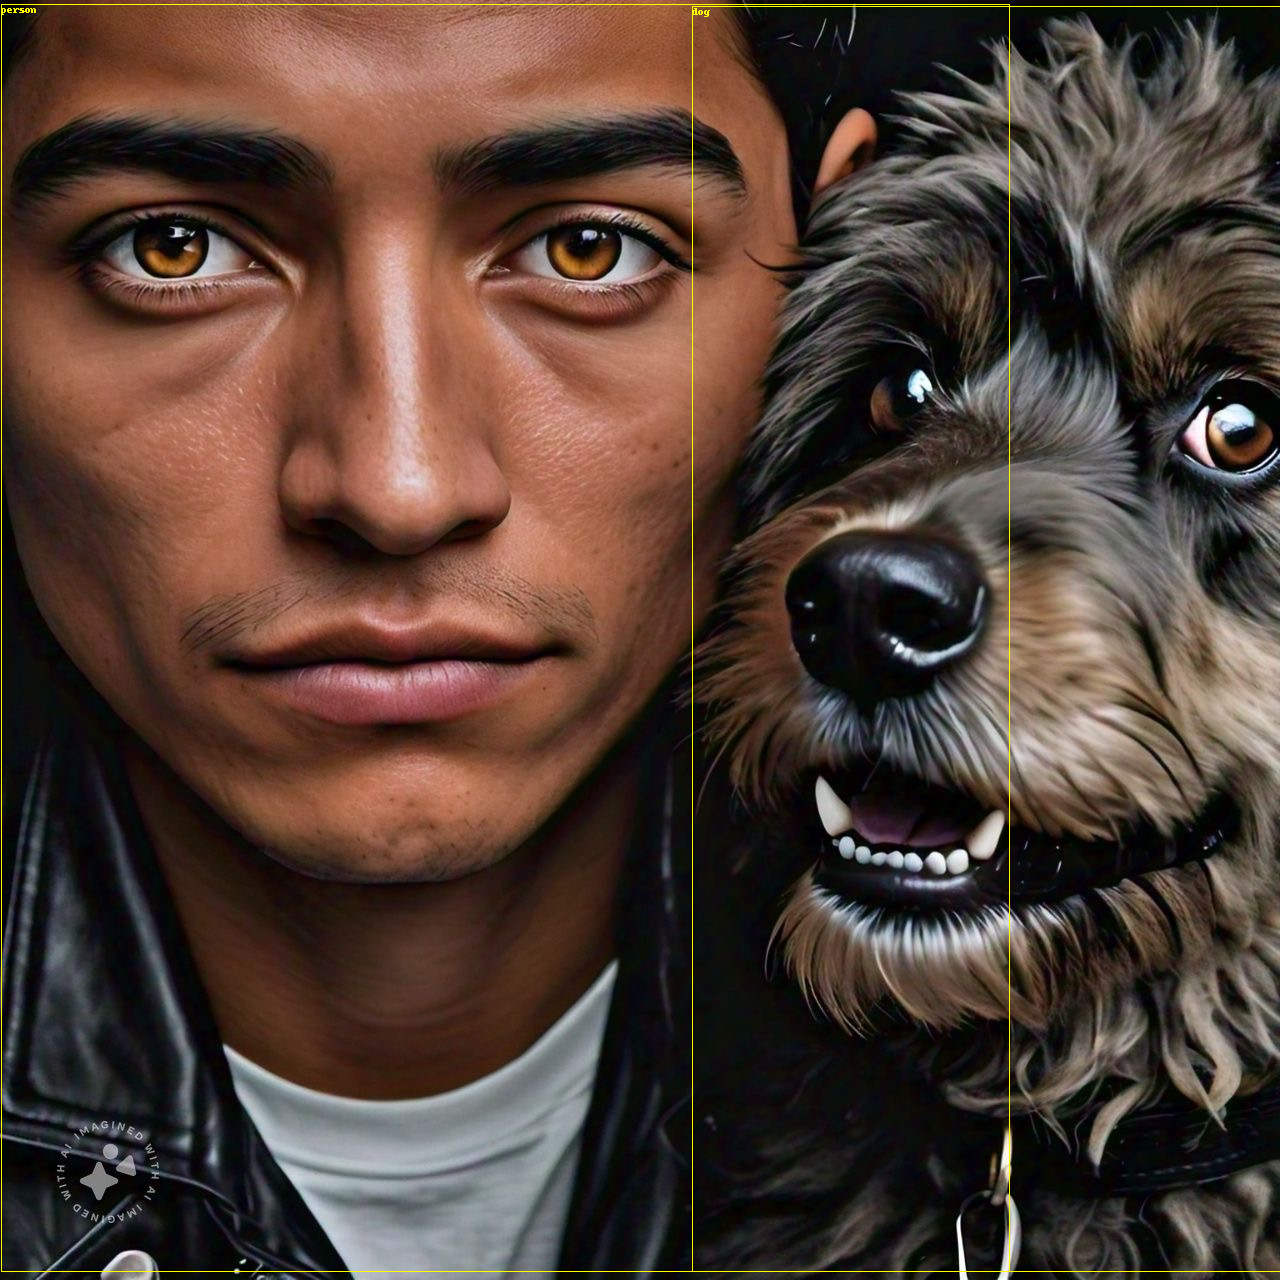

In [10]:
# Let's test another image, this time stored
path= "test.jpeg"
image = Image.open(path)

predictions = detect_objects(image)
display_results(predictions)
draw_objects(image, predictions, config, color="yellow")
image

# Image segmentation

With segmentation, we will split an image into areas that are semantically related.

Each segment represents "something", which is defined by the model. The segments can be visualized and used as masks.

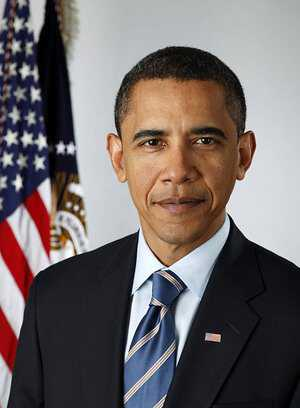

In [11]:
# Let's fetch an image of President Obama as an example
url = "https://www.pbs.org/wgbh/americanexperience/media/filer_public_thumbnails/filer_public/f1/ab/f1abc273-b058-4a97-aab5-b9e5e0e4931d/presidents_obama_loc.jpg__300x408_q85_crop_subsampling-2.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

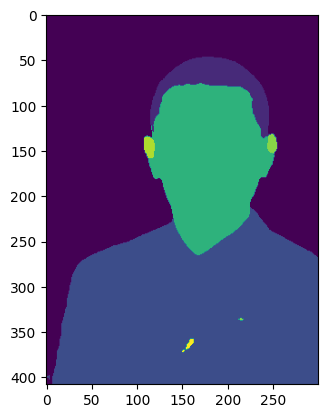

In [12]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import matplotlib.pyplot as plt
import torch.nn as nn

# Load the processor and model
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

# Pre process the image
inputs = processor(images=image, return_tensors="pt")

# The output will be logits over the pixels
outputs = model(**inputs)
logits = outputs.logits.cpu()

# We have to interpolate the logits to cover all of the image
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

# The result is a bitmap with the regions coded by different values, which we can draw on screen
pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg)